# Importación de _data_

In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [199]:

first_row = ['ligero', 'moto', 'auto', 'station_wagon', 'pesado', 'muy_pesado']
second_row = ['bicicleta', 'moto_lineal', 'trimoto', 'moto_carga', 'particular', 'colectivo', 'taxi', 'particular', 'colectivo', 'taxi', 'miniban', 'microbus', 'camioneta', 'bus', '<12tn', '>12tn']
column_index = pd.MultiIndex.from_tuples([
    *zip( ((first_row[0] * 1, ) + (first_row[1], ) * 3 + (first_row[2], ) * 3 + (first_row[3], ) * 3 + (first_row[4], ) * 4 + (first_row[5], ) * 2), second_row )
])

In [201]:
DATA_PATH = './data/test.xlsx'
data = pd.read_excel(DATA_PATH)
data = data.dropna(how='any')
data = data.set_index('Hora')
# data.index.name = 'hora'
data.columns = column_index
hora = data.index.str.extract('^(\d\d:\d\d)').astype('string').values
data.index = pd.Index(hora.ravel(), name='hora', dtype=str)
data.index = pd.to_datetime(data.index)
data.head()

ligero        moto                          auto  \
                    bicicleta moto_lineal trimoto moto_carga particular   
hora                                                                      
2022-10-04 13:15:00        36           7      32         35         30   
2022-10-04 13:30:00        15          26      21         33         35   
2022-10-04 13:45:00        24          21      29         29          5   
2022-10-04 14:00:00        11          11      10         30         10   
2022-10-04 14:15:00         5          24       6         13         23   

                                   station_wagon                 pesado  \
                    colectivo taxi    particular colectivo taxi miniban   
hora                                                                      
2022-10-04 13:15:00        33   31            17        36   30      32   
2022-10-04 13:30:00        19   11            23        36   36      13   
2022-10-04 13:45:00        39   26            32        13   10      27   
2022-10-04 14:00:00        38   39            24        21   21      16   
2022-10-04 14:15:00        32   22            25        19   10      21   

                                           muy_pesado        
                    microbus camioneta bus      <12tn >12tn  
hora                                                         
2022-10-04 13:15:00       37        19  27          5    12  
2022-10-04 13:30:00       22        32  14         23    30  
2022-10-04 13:45:00        5        36  11         33    22  
2022-10-04 14:00:00       31         6  34         29    24  
2022-10-04 14:15:00       12         8  32          9    35

## Gráficas por tipo

In [281]:
period = '15T' # -> 15 minutos
data_resampled = data.resample(rule=period,label='left',closed='left').sum()

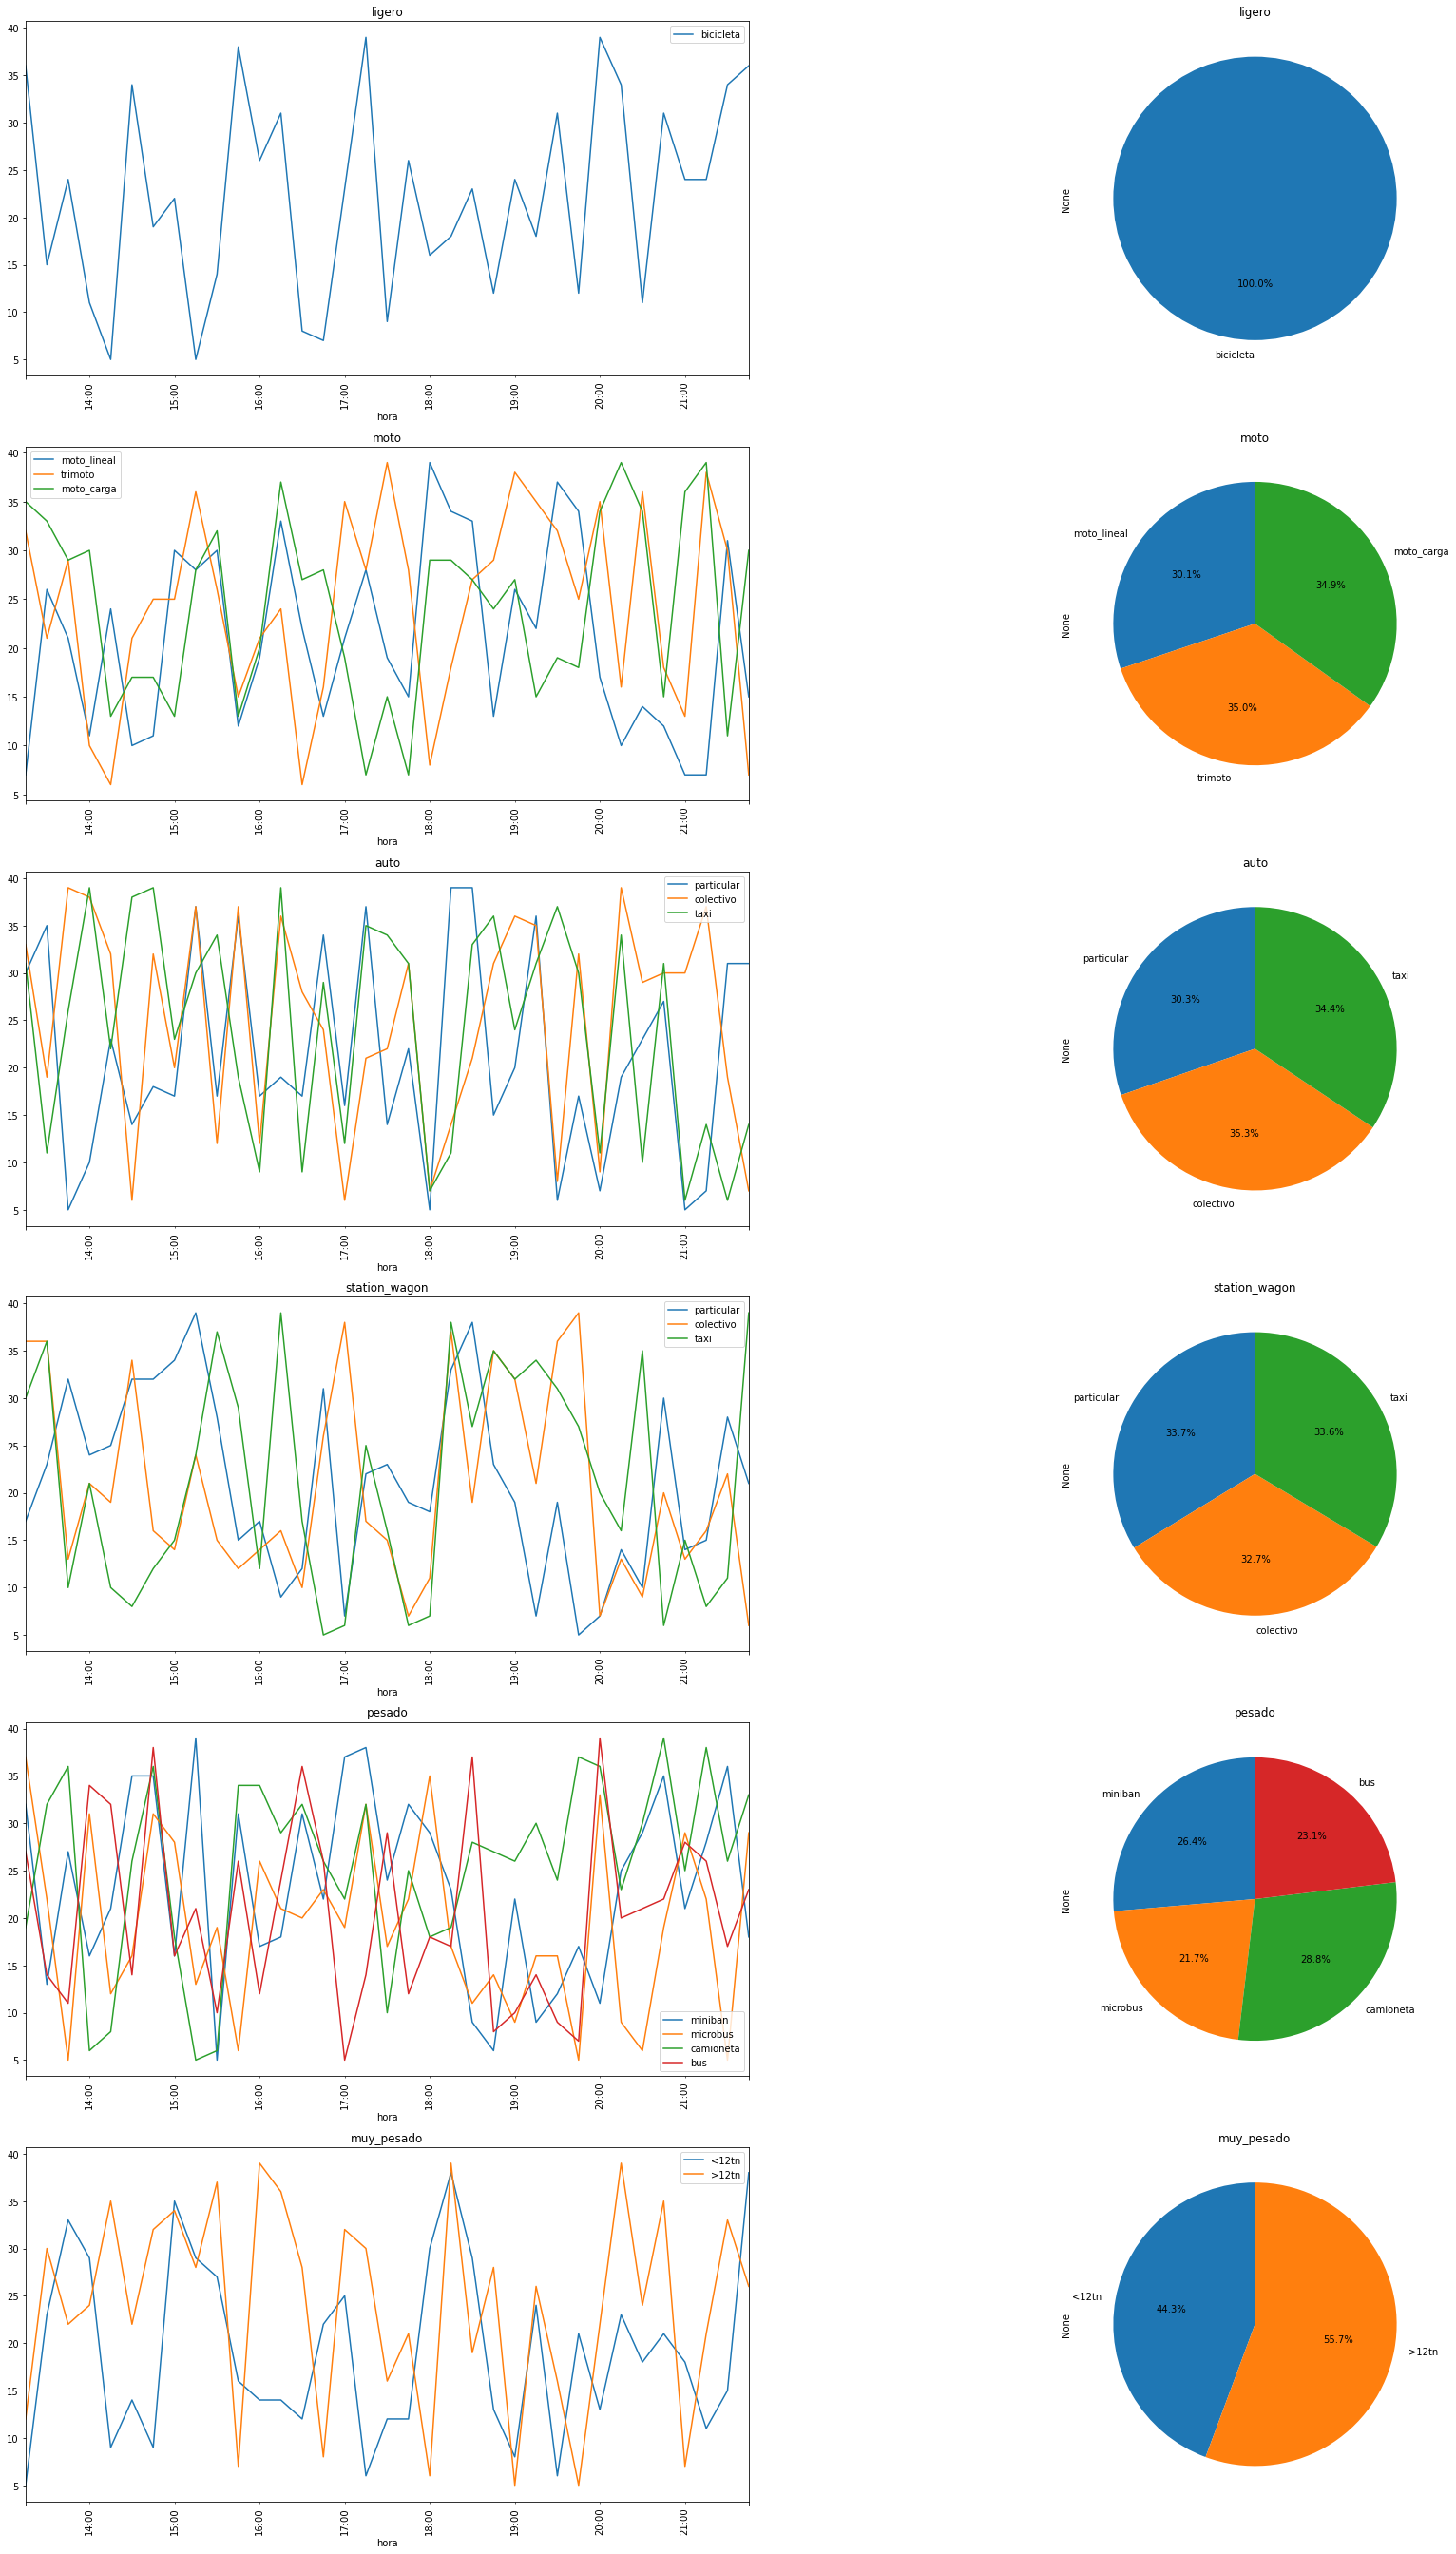

In [287]:
counter_idx = 0
g = []
pies = []
fig, axes = plt.subplots(len(first_row), 2, figsize=(30,48))
# plt.xticks(ticks = data_resampled.index,labels=[str(i) for i in data_resampled.index])
for ax, column_1 in zip(axes.reshape(-1,2), first_row):
    data_ = data_resampled[column_1]
    ax[0].set_title(column_1)
    data_.plot(ax=ax[0], rot=90)
    ax[1].set_title(column_1)
    data_.sum(axis=0).plot.pie(ax=ax[1], autopct='%1.1f%%', startangle=90)
plt.show()

['2022-10-04 13:00:00',
 '2022-10-04 13:30:00',
 '2022-10-04 14:00:00',
 '2022-10-04 14:30:00',
 '2022-10-04 15:00:00',
 '2022-10-04 15:30:00',
 '2022-10-04 16:00:00',
 '2022-10-04 16:30:00',
 '2022-10-04 17:00:00',
 '2022-10-04 17:30:00',
 '2022-10-04 18:00:00',
 '2022-10-04 18:30:00',
 '2022-10-04 19:00:00',
 '2022-10-04 19:30:00',
 '2022-10-04 20:00:00',
 '2022-10-04 20:30:00',
 '2022-10-04 21:00:00',
 '2022-10-04 21:30:00']